# EDA – Features Semanais (features_weekly.parquet)

Exploração das features semanais já geradas e análise do alvo (classe de risco).

Pré‑requisitos:
- Ter rodado `python main.py features` (ou `python main.py all`) para gerar `data/features/features_weekly.parquet`.


In [1]:
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

sns.set_context('talk'); sns.set_style('whitegrid')

# Garantir import de 'src' subindo diretórios até encontrar a raiz do repo
repo_root = Path.cwd().resolve()
for _ in range(8):
    if (repo_root / 'src').exists():
        break
    repo_root = repo_root.parent
assert (repo_root / 'src').exists(), f"Não encontrei 'src' a partir de {Path.cwd()}"
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('repo_root:', repo_root)

from src.train import rotular_semana, compute_label_thresholds


repo_root: D:\OneDrive\Documentos\Profissional\Pós IA IFG\Matérias\Trabalho Final Módulo 2\versaoGitHub


## Carregar features semanais e configuração

In [13]:
cfg_path = repo_root / 'configs' / 'config.yaml'
cfg = yaml.safe_load(open(cfg_path, 'r', encoding='utf-8'))
feats_path = repo_root / 'data' / 'features' / 'features_weekly.parquet'
assert feats_path.exists(), f'Arquivo não encontrado: {feats_path}'
Xw = pd.read_parquet(feats_path)
Xw = Xw.dropna(axis=1, how='all')
Xw.head(100)



,carga_mwh_mean_w,carga_mwh_sum_w,carga_mwh_max_w,carga_mwh_min_w,carga_mwh_std_w,carga_mwh__p95_w,carga_mwh__p05_w,ger_hidreletrica_mwh_mean_w,ger_hidreletrica_mwh_sum_w,ger_hidreletrica_mwh_max_w,...,ger_renovavel_mwh_sum_w_r2w_std,ger_renovavel_mwh_sum_w_r4w_mean,ger_renovavel_mwh_sum_w_r4w_std,ratio_corte_renovavel_w_lag1w,ratio_corte_renovavel_w_lag2w,ratio_corte_renovavel_w_lag4w,ratio_corte_renovavel_w_r2w_mean,ratio_corte_renovavel_w_r2w_std,ratio_corte_renovavel_w_r4w_mean,ratio_corte_renovavel_w_r4w_std
data,,,,,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766091.283286,5.362639e+06,802961.033,...,NaN,8705.876000,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2018-01-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810242.518714,5.671698e+06,845447.439,...,3617.012406,11263.490000,3617.012406,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2018-01-21 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844464.356286,5.911250e+06,910535.054,...,1324.355140,12740.335000,3617.264551,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-01-28 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,856964.499705,5.998751e+06,910114.196,...,1441.085749,12969.256747,2988.760483,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2018-02-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825837.654000,5.780864e+06,866514.214,...,4409.288777,12647.874247,3605.501163,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-03 00:00:00+00:00,2.022797e+06,1.415958e+07,2156051.623,1762809.089,157218.015158,2.152028e+06,1.786750e+06,664041.148428,4.648288e+06,713990.631,...,4214.387529,35832.731500,2861.915492,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-10 00:00:00+00:00,2.010932e+06,1.407652e+07,2193864.629,1734388.334,152931.298976,2.168537e+06,1.782183e+06,662000.954143,4.634007e+06,750526.382,...,1689.062433,35735.899000,2871.373049,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-17 00:00:00+00:00,1.862291e+06,1.303604e+07,2003370.755,1605967.860,169367.648685,2.000965e+06,1.631836e+06,618833.559000,4.331835e+06,668463.936,...,4115.221459,33630.049000,3654.763800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploração dos dados

In [15]:
print('Período:', Xw.index.min(), '->', Xw.index.max(), f'({len(Xw)} semanas)')
print('Total de features:', Xw.shape[1])
miss = Xw.isna().mean().sort_values(ascending=False)
miss.head(20)


Período: 2018-01-07 00:00:00+00:00 -> 2025-09-21 00:00:00+00:00 (403 semanas)
Total de features: 896


reserve_margin_ratio_w_lag4w    0.168734
margem_vs_carga_w_lag4w         0.168734
ens_week_ratio_lag4w            0.168734
ens_week_mwh_lag4w              0.168734
carga_mwh_max_w_lag4w           0.168734
carga_mwh__p95_w_lag4w          0.168734
carga_mwh__p05_w_lag4w          0.168734
carga_mwh_sum_w_lag4w           0.168734
carga_mwh_std_w_lag4w           0.168734
carga_mwh_mean_w_lag4w          0.168734
carga_mwh_min_w_lag4w           0.168734
ens_week_mwh_lag2w              0.163772
carga_mwh_max_w_lag2w           0.163772
reserve_margin_ratio_w_lag2w    0.163772
ens_week_ratio_lag2w            0.163772
margem_vs_carga_w_lag2w         0.163772
carga_mwh_mean_w_lag2w          0.163772
carga_mwh_std_w_lag2w           0.163772
carga_mwh_min_w_lag2w           0.163772
carga_mwh_sum_w_lag2w           0.163772
dtype: float64

In [16]:
# Estatísticas de colunas-chave (usa o que existir)
keys = [
 'margem_vs_carga_w','margem_suprimento_w','reserve_margin_ratio_w',
 'ens_week_mwh','ens_week_ratio','lolp_52w',
 'geracao_total_mwh_sum_w','import_total_mwh_sum_w','export_total_mwh_sum_w',
 'ear_pct_mean_w','ena_mwmed_mean_w','corte_renovavel_mwh_sum_w','ratio_corte_renovavel_w'
]
sel = [c for c in keys if c in Xw.columns]
(Xw[sel] if sel else Xw).describe().T


,count,mean,std,min,25%,50%,75%,max
margem_vs_carga_w,339.0,-7.179262e+06,567519.020440,-8.991386e+06,-7.563267e+06,-7.118724e+06,-6.783523e+06,-2.793459e+06
margem_suprimento_w,403.0,6.667121e+06,733000.736635,2.136912e+06,6.210115e+06,6.644593e+06,7.080468e+06,8.902049e+06
reserve_margin_ratio_w,339.0,-5.164048e-01,0.021864,-7.399431e-01,-5.230868e-01,-5.123503e-01,-5.048307e-01,-3.013612e-01
ens_week_mwh,339.0,7.179262e+06,567519.020440,2.793459e+06,6.783523e+06,7.118724e+06,7.563267e+06,8.991386e+06
ens_week_ratio,339.0,5.164048e-01,0.021864,3.013612e-01,5.048307e-01,5.123503e-01,5.230868e-01,7.399431e-01
lolp_52w,392.0,7.997449e-01,0.372029,0.000000e+00,8.798077e-01,1.000000e+00,1.000000e+00,1.000000e+00
geracao_total_mwh_sum_w,403.0,6.013000e+06,679876.819409,1.739055e+06,5.555035e+06,5.989047e+06,6.448792e+06,8.031443e+06
import_total_mwh_sum_w,403.0,1.027000e+06,568578.085378,-5.057755e+05,6.042074e+05,1.008649e+06,1.399270e+06,2.277797e+06
export_total_mwh_sum_w,403.0,3.728799e+05,526501.308608,-7.848492e+05,-3.994609e+04,3.077423e+05,7.893382e+05,1.442118e+06
ear_pct_mean_w,403.0,5.932998e+01,17.325444,2.512416e+01,4.567824e+01,6.023232e+01,7.252198e+01,9.018607e+01


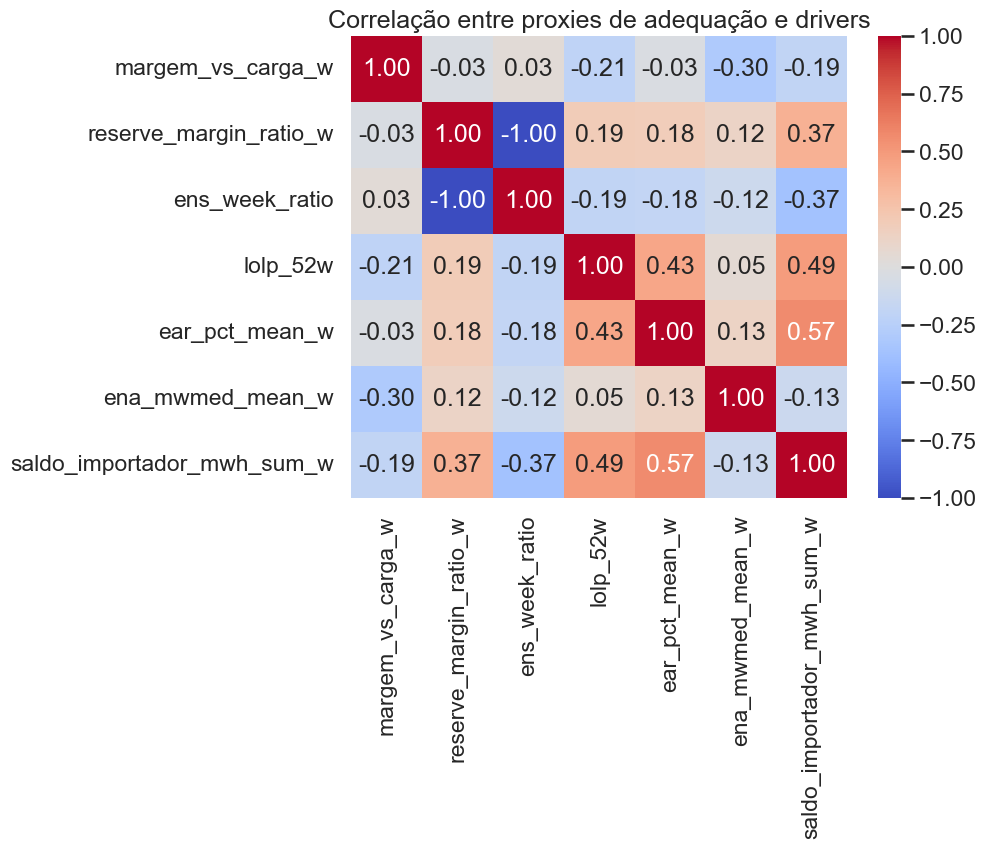

In [17]:
# Correlação entre proxies de adequação e drivers (se disponíveis)
corr_cols = [c for c in [
 'margem_vs_carga_w','reserve_margin_ratio_w','ens_week_ratio','lolp_52w',
 'ear_pct_mean_w','ena_mwmed_mean_w','saldo_importador_mwh_sum_w'
] if c in Xw.columns]
if len(corr_cols) >= 2:
    corr = Xw[corr_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlação entre proxies de adequação e drivers')
    plt.show()
else:
    print('Colunas insuficientes para matriz de correlação selecionada.')


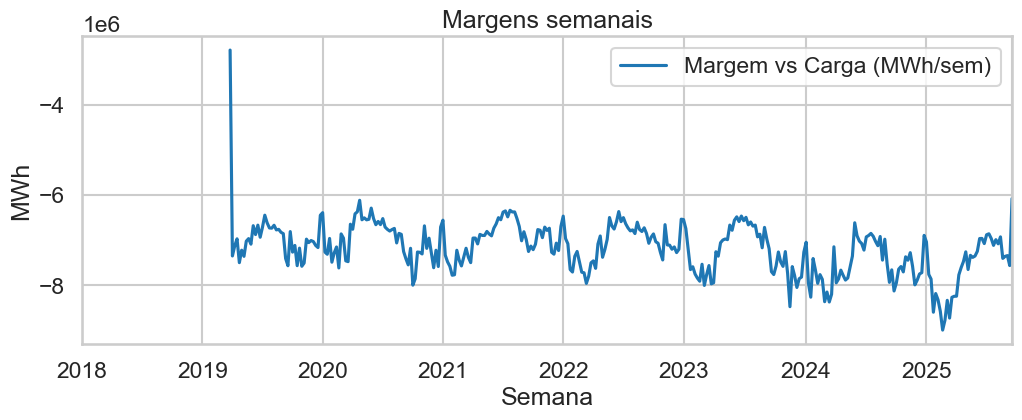

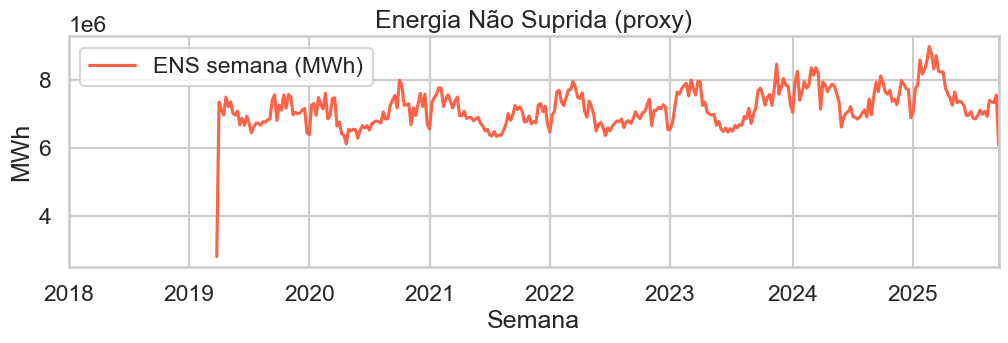

In [18]:
# Séries temporais das margens/ENS (se existirem)
plt.figure(figsize=(12,4))
if 'margem_vs_carga_w' in Xw.columns:
    Xw['margem_vs_carga_w'].plot(label='Margem vs Carga (MWh/sem)')
elif 'margem_suprimento_w' in Xw.columns:
    Xw['margem_suprimento_w'].plot(label='Margem de Suprimento (MWh/sem)')
plt.legend(); plt.title('Margens semanais'); plt.xlabel('Semana'); plt.ylabel('MWh'); plt.show()

if 'ens_week_mwh' in Xw.columns:
    plt.figure(figsize=(12,3))
    Xw['ens_week_mwh'].plot(color='tomato', label='ENS semana (MWh)')
    plt.legend(); plt.title('Energia Não Suprida (proxy)'); plt.xlabel('Semana'); plt.ylabel('MWh'); plt.show()


## Analisando o Alvo (target)

In [19]:
# Rótulo semanal segundo config atual (sem vazamento, thresholds calculados no próprio Xw)
thr = compute_label_thresholds(cfg, Xw)
y = rotular_semana(Xw, cfg, ref_df=Xw)
H = int(cfg.get('problem', {}).get('forecast_horizon_weeks', 1))
if H > 0: y = y.shift(-H)
y = y.dropna()
print('Semanas rotuladas:', len(y))
y.value_counts()


Semanas rotuladas: 373


alto     166
baixo    165
medio     42
Name: count, dtype: int64

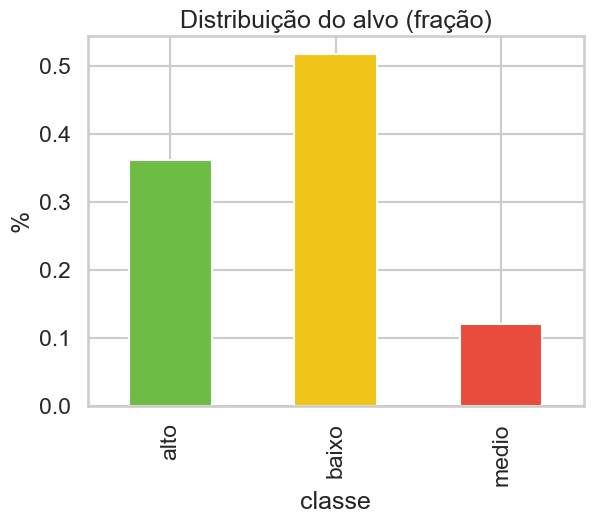

alto     0.361702
baixo    0.517730
medio    0.120567
Name: proportion, dtype: float64

In [17]:
# Distribuição de classes (fração)
vc = y.value_counts(normalize=True).sort_index()
ax = vc.plot(kind='bar', color=['#6dbd45','#f0c419','#e74c3c'])
ax.set_title('Distribuição do alvo (fração)'); ax.set_xlabel('classe'); ax.set_ylabel('%');
plt.show(); vc


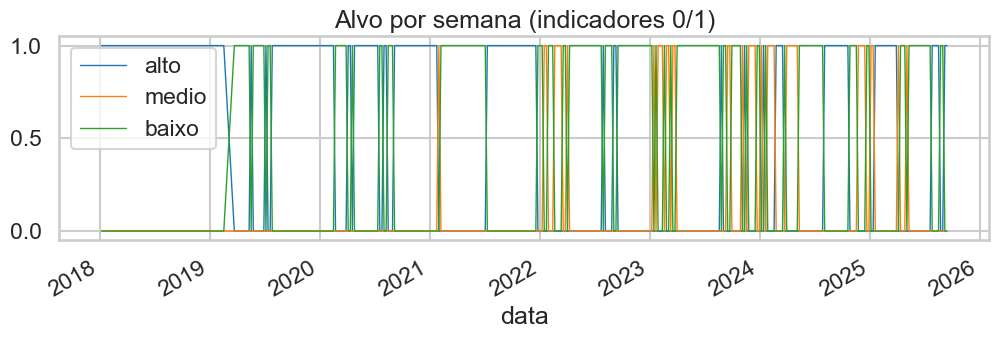

In [20]:
# Alvo por semana (indicadores 0/1)
fig, ax = plt.subplots(figsize=(12,3))
(y=='alto').astype(int).plot(ax=ax, lw=1, label='alto')
(y=='medio').astype(int).plot(ax=ax, lw=1, label='medio')
(y=='baixo').astype(int).plot(ax=ax, lw=1, label='baixo')
ax.set_title('Alvo por semana (indicadores 0/1)'); ax.legend(); plt.show()


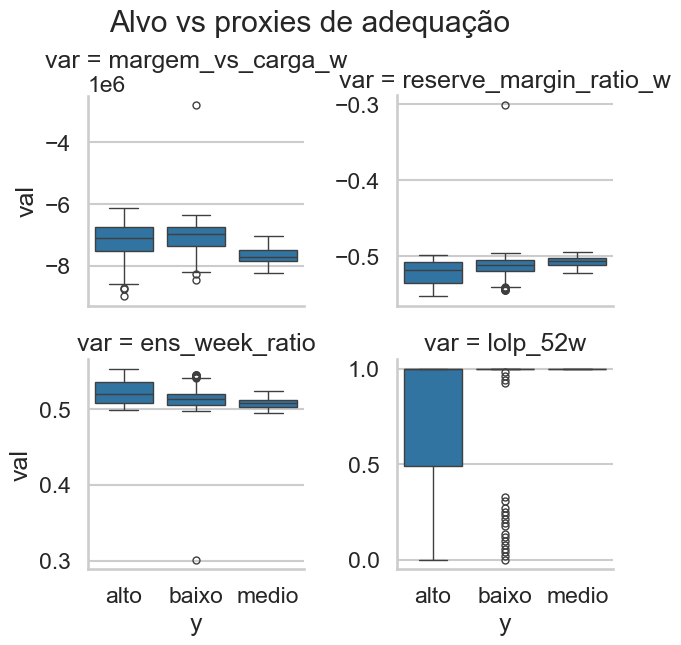

In [21]:
# Relação do alvo com proxies de adequação (boxplots)
dfy = pd.DataFrame({'y': y})
for col in ['margem_vs_carga_w','reserve_margin_ratio_w','ens_week_ratio','lolp_52w']:
    if col in Xw.columns: dfy[col] = Xw[col].reindex(dfy.index)
if dfy.shape[1] > 1:
    sns.catplot(data=dfy.melt('y', var_name='var', value_name='val'), x='y', y='val', col='var', kind='box', sharey=False, col_wrap=2, height=3.2)
    plt.suptitle('Alvo vs proxies de adequação', y=1.02); plt.show()
else:
    print('Sem colunas de proxies para plotar contra o alvo.')
